In [1]:
import sys
sys.path.insert(0,'/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/3. Semester/Python For The Financial Economist')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.covariance import corr_to_cov_matrix, form_block_corr_matrix, corr_to_cov_matrix, cov_to_corr_matrix

from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks, calculate_risk_contributions, calculate_marginal_sharpe

from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart, correlation_plot, fan_chart

# Views
from codelib.portfolio_optimization.views import ProbabilitySolver, CorrelationView,MeanView, VolatilityView, weighted_percentile
from codelib.portfolio_optimization.views import effective_sample_size_entropy, calculate_correlation, View
from codelib.portfolio_optimization.views import calculate_correlation, calculate_variance, calculate_std, calculate_covariance


# fixed income 
from codelib.fixed_income.curves.cir_curve import CIRCurve
from codelib.fixed_income.cash_flows import CashFlow

ModuleNotFoundError: No module named 'codelib.statistics'

In [207]:
pip install codelib

Note: you may need to restart the kernel to use updated packages.


## Question 2

In [4]:
mu = np.array([0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038])
vols = np.array([0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094])
corr_mat = np.array([[1.0, 0.6, 0.1, 0.3, -0.1, -0.1, -0.2, -0.1, -0.1, -0.1],
                     [0.6, 1.0, 0.6, 0.6, 0.2, 0.2, 0.2, 0.1, 0.1, 0.3],
                     [0.1, 0.6, 1.0, 0.7, 0.7, 0.6, 0.6, 0.4, 0.3, 0.7],
                     [0.3, 0.6, 0.7, 1.0, 0.5, 0.6, 0.4, 0.2, 0.2, 0.5],
                     [-0.1, 0.2, 0.7, 0.5, 1.0, 0.7, 0.8, 0.4, 0.4, 0.8],
                     [-0.1, 0.2, 0.6, 0.6, 0.7, 1.0, 0.7, 0.4, 0.4, 0.7],
                     [-0.2, 0.2, 0.6, 0.4, 0.8, 0.7, 1.0, 0.4, 0.4, 0.7],
                     [-0.1, 0.1, 0.4, 0.2, 0.4, 0.4, 0.4, 1.0, 0.3, 0.4],
                     [-0.1, 0.1, 0.3, 0.2, 0.4, 0.4, 0.4, 0.3, 1.0, 0.4],
                     [-0.1, 0.3, 0.7, 0.5, 0.8, 0.7, 0.7, 0.4, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

array([[ 0.001369 ,  0.001221 ,  0.0004403,  0.0011877, -0.0005661,
        -0.0008029, -0.0015096, -0.000518 , -0.0003996, -0.0003478],
       [ 0.001221 ,  0.003025 ,  0.003927 ,  0.003531 ,  0.001683 ,
         0.002387 ,  0.002244 ,  0.00077  ,  0.000594 ,  0.001551 ],
       [ 0.0004403,  0.003927 ,  0.014161 ,  0.0089131,  0.0127449,
         0.0154938,  0.0145656,  0.006664 ,  0.0038556,  0.0078302],
       [ 0.0011877,  0.003531 ,  0.0089131,  0.011449 ,  0.0081855,
         0.0139314,  0.0087312,  0.002996 ,  0.0023112,  0.005029 ],
       [-0.0005661,  0.001683 ,  0.0127449,  0.0081855,  0.023409 ,
         0.0232407,  0.0249696,  0.008568 ,  0.0066096,  0.0115056],
       [-0.0008029,  0.002387 ,  0.0154938,  0.0139314,  0.0232407,
         0.047089 ,  0.0309876,  0.012152 ,  0.0093744,  0.0142786],
       [-0.0015096,  0.002244 ,  0.0145656,  0.0087312,  0.0249696,
         0.0309876,  0.041616 ,  0.011424 ,  0.0088128,  0.0134232],
       [-0.000518 ,  0.00077  ,  0.006664

In [5]:
def calculate_optimal_weights_alternative(mu: np.ndarray, cov_matrix: np.ndarray, risk_aversion: float) -> np.ndarray: 
    
    """
    Function that calculates optimal port. weights
    
    Parameters
    ----------
    mu: 
        Expected returns
    cov_matrix: 
        Covariance matrix
    risk_aversion: 
        Risk aversion parameter
    
    Returns
    -------
    float
        Optimal portfolio weights
    """
    
    ones = np.ones_like(mu)
    sigma_inv = np.linalg.inv(cov_matrix)
    
    a = ones @  sigma_inv @ mu
    b = ones @  sigma_inv @ ones
    
    r_inv = 1.0 / risk_aversion
    
    gamma = a / b - risk_aversion / b 
    
    opt_weights = r_inv * sigma_inv @mu - r_inv * gamma * sigma_inv @ ones
    
    return opt_weights

In [6]:
risk_aversion = 5
print("optimal weights: ")
w_opt = calculate_optimal_weights_alternative(mu, cov_mat, risk_aversion)
w_opt

optimal weights: 


array([ 1.340008  , -1.22071065,  0.31584251,  0.3366493 , -0.3598723 ,
       -0.04895523,  0.60319508,  0.19529637,  0.1471628 , -0.30861588])

In [7]:
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [41]:
"""
Simulate asset prices
"""

num_sim = 5000
dt = 1.0
horizon = 5.0
mu = mu
cov_mat = cov_mat

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)
asset_prices

array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.00662639, 1.05388804, 1.01596272, ..., 0.92670001,
         0.97402977, 1.10574782],
        [1.03034615, 1.0719563 , 1.11220328, ..., 0.77772513,
         1.01635289, 1.27132498],
        [0.99233856, 0.98036374, 0.94949435, ..., 0.7285412 ,
         1.15175193, 1.19935803],
        [1.01469968, 1.02264968, 0.97637369, ..., 0.8427403 ,
         1.08254401, 1.29085603],
        [1.04178053, 1.09493288, 1.17416081, ..., 0.95774014,
         0.99917634, 1.39076209]],

       [[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.00026847, 1.06067461, 1.03839674, ..., 1.20295948,
         1.14286027, 1.09689498],
        [1.04791908, 1.14347727, 1.11249609, ..., 1.48896867,
         1.31939746, 1.19884758],
        [1.04489223, 1.23963143, 1.55990403, ..., 1.72892475,
         1.14271927, 1.317403  ],
        [1.04464303, 1.3649589 , 1.813

In [42]:
asset_prices.shape

(5000, 6, 10)

In [43]:
asset_1 = asset_prices[:,5:6,:1]
asset_2 = asset_prices[:,5:6,1:2]
asset_3 = asset_prices[:,5:6,2:3]
asset_4 = asset_prices[:,5:6,3:4]
asset_5 = asset_prices[:,5:6,4:5]
asset_6 = asset_prices[:,5:6,5:6]
asset_7 = asset_prices[:,5:6,6:7]
asset_8 = asset_prices[:,5:6,7:8]
asset_9 = asset_prices[:,5:6,8:9]
asset_10 = asset_prices[:,5:6,9:10]
A1 = asset_1[:,0,0]
A2 = asset_2[:,0,0]
A3 = asset_3[:,0,0]
A4 = asset_4[:,0,0]
a5 = asset_5[:,0,0]
a6 = asset_6[:,0,0]
a7 = asset_7[:,0,0]
a8 = asset_8[:,0,0]
a9 = asset_9[:,0,0]
a10 = asset_10[:,0,0]
data1 = [A1,A2,A3,A4,a5,a6,a7,a8,a9,a10]

AttributeError: 'dict' object has no attribute 'set_ylabel'

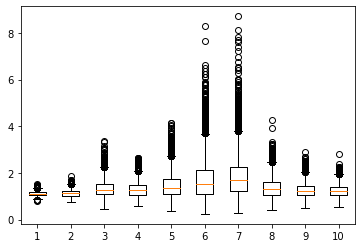

In [44]:
ax=plt.boxplot(data1)
ax.set_ylabel("Price")
ax.set_xlabel("Assets")

In [45]:
"""
Buy and hold strategy 
"""

port_w = np.ones(len(mu)) / len(mu)

buy_and_hold_index = asset_prices @ port_w

In [46]:
buy_and_hold_index

array([[1.        , 1.00766431, 1.09201184, 1.15075117, 1.17738555,
        1.27619781],
       [1.        , 1.1047231 , 1.16971809, 1.39863262, 1.67742337,
        1.68890848],
       [1.        , 0.97969635, 1.01625309, 1.35059293, 1.47299242,
        1.4915514 ],
       ...,
       [1.        , 1.22477169, 1.19904264, 1.29217548, 1.57425289,
        1.71136725],
       [1.        , 0.91551916, 0.95923788, 0.94664209, 0.98242939,
        1.06089573],
       [1.        , 1.08584104, 1.14713148, 1.3650766 , 1.42400807,
        1.47556088]])

In [47]:
buy_and_hold_index.shape

(5000, 6)

NameError: name 'fan_chart' is not defined

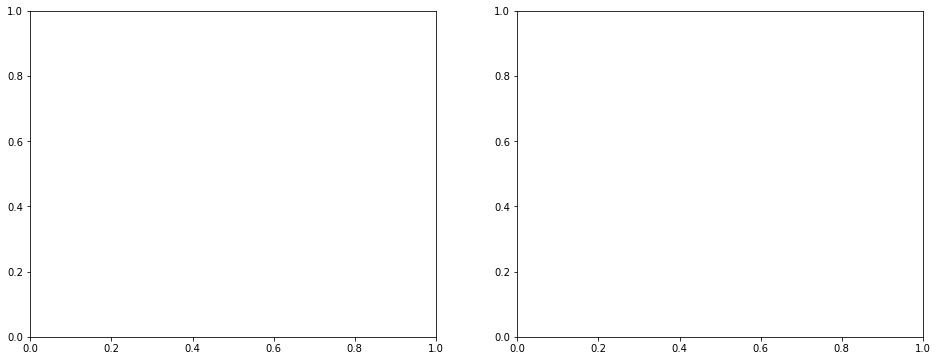

In [48]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

In [ ]:
np.mean(buy_and_hold_index[:, 5])

In [49]:
np.median(buy_and_hold_index[:, 5])

1.3390268748185905

Transactions Costs

In [60]:
a0 = 500000

In [76]:
a5_y0 = asset_prices[:,0:1,4:5]
a5_y1 = asset_prices[:,1:2,4:5]
a5_y2 = asset_prices[:,2:3,4:5]
a5_y3 = asset_prices[:,3:4,4:5]
a5_y4 = asset_prices[:,4:5,4:5]
a5_y5 = asset_prices[:,5:6,4:5]

In [90]:
a5_y0_mean = np.mean(a5_y0)
a5_y1_mean = np.mean(a5_y1)
a5_y2_mean = np.mean(a5_y2)
a5_y3_mean = np.mean(a5_y3)
a5_y4_mean = np.mean(a5_y4)
a5_y5_mean = np.mean(a5_y5)
k = 0.02

In [109]:
a5_y0_ret = (a5_y0_mean*a0-a0)*0.02
a5_y1_ret = (a5_y1_mean*a0-a0)*0.02
a5_y2_ret = (a5_y2_mean*a0-a0)*0.02
a5_y3_ret = (a5_y3_mean*a0-a0)*0.02
a5_y4_ret = (a5_y4_mean*a0-a0)*0.02
a5_y5_ret = (a5_y5_mean*a0-a0)*0.02

In [114]:
x = np.array(1,2,4,5).reshape((-1,1))
y = np.array(a5_y0_ret,a5_y1_ret,a5_y2_ret,a5_y3_ret,a5_y4_ret,a5_y5_ret)

TypeError: array() takes from 1 to 2 positional arguments but 4 were given